In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import scipy.io.wavfile as wavfile
import random
import os
import glob
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

MASTER_FS = 44100

In [2]:
fs, x = wavfile.read("music/Acoustic/andy_mckee_art_of_motion/Art_Of_Motion.wav")
x.shape

(9065784, 2)

In [3]:
def read_song(fname):
    fs, x = wavfile.read(fname)
    assert(x.shape[1] == 2)
    assert(fs == MASTER_FS)  # If not true gonna have to resample
    
    return x

def random_n_seconds(song, n, fs):
    samples = x.shape[0]
    snip_length = fs*n
    index = random.randint(0, samples-snip_length)
    return song[index:index+snip_length]

def stereo_spectrogram(sample, fs):
    f, t, sxx0 = sig.spectrogram(sample[:, 0], fs=fs)
    _, _, sxx1 = sig.spectrogram(sample[:, 1], fs=fs)
    
    return (f, t, sxx0, sxx1)

def flattened_spectrograms(sample, fs):
    f, t, sxx0, sxx1 = stereo_spectrogram(sample, fs)
    
    return np.concatenate((np.ravel(sxx0), np.ravel(sxx1)))

def svd_of_stacked_spectrograms(sxx0, sxx1):
    data_matrix = np.vstack((sxx0, sxx1)).T
    u, s, vh = np.linalg.svd(data_matrix, full_matrices=False)
    
    return u, s, vh

def reconstruct_n_modes(u, s, vh, modes=None):
    if modes is None:
        modes = s.shape[0]
        
    print("u.shape: {}; vh.shape: {}".format(u.shape, vh.shape))
    s_diag = np.zeros((u.shape[0], vh.shape[0]))
    s_diag[:u.shape[1], :u.shape[1]] = np.diag(s)
    
    return np.matmul(np.matmul(u[:,0:modes], s_diag[0:modes, 0:modes]), vh[0:modes, :]).T

def keep_n_modes(u, s, vh, n):
    return (u[:,:n], s[:n], vh[:n, :])

def process_song(fname, label, num_samples):
    x = read_song(fname)
    samples = []
    full_song = read_song(fname)
    for i in range(num_samples):
        samples.append(random_n_seconds(full_song, 5, MASTER_FS))
        
    return [(sample, label) for sample in samples]
        

# SVD
##### As explained by Kesley Maass
If we construct a data matrix $x$ such that
$$X\in \mathbb{R}^{T\times F}$$
with T samples in F frequency bins,then taking the SVD will produce the following:
$$U\in \mathbb{R}^{T\times F}$$
Each column of $U$ contains the displacement along a mode.
$$\Sigma \in \mathbb{R}^{F\times F}$$
Each diagonal will contain the singular values, ordering the relative "importance" of each mode.
$$V \in \mathbb{R}^{F\times F}$$
will contain the "directions" (if in space) of the modes. These will correspond to the frequencies of each spectrogram here.

We can then project the (new?) data onto the SVD basis by doing:
$$U^{T}X$$
and a lower rank approximation can be achieved by using only the top $k$ columns of U.

In [4]:
# Band classification
def sample_and_label(folder, label, samples):
    files = glob.glob(folder+"/*.wav")
    labeled_data = []
    for f in files:
        labeled_data = labeled_data + process_song(f, label, samples)
        
    return labeled_data

labeled = []
labeled += sample_and_label("music/Metal/monuments_the_amanuensis", "Monuments", 30)
labeled += sample_and_label("music/Acoustic/andy_mckee_art_of_motion", "Andy Mckee", 30)
labeled += sample_and_label("music/Jazz/herbie_hancock_headhunters", "Herbie Hancock", 50)

print(labeled[0][0].size)
initial = len(labeled)
labeled = [i for i in labeled if i[0].size == 441000]
print("Removed {} entries for insufficient size.".format(initial-len(labeled)))

441000
Removed 11 entries for insufficient size.


In [5]:
print(len(labeled))

969


In [6]:
labeled_spectrogram_vectors = [(flattened_spectrograms(i[0], MASTER_FS), i[1]) for i in labeled]
del labeled

Text(0.5, 1.0, 'Monuments')

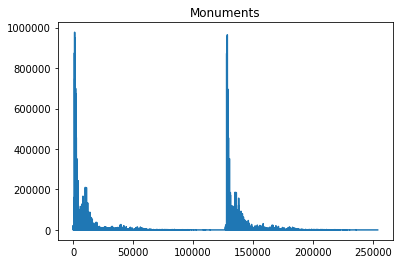

In [7]:
plt.figure()
plt.plot(labeled_spectrogram_vectors[2][0])
plt.title(labeled_spectrogram_vectors[2][1])

In [ ]:
#X = np.array([i[0] for i in labeled_spectrogram_vectors])
nom = labeled_spectrogram_vectors[0]
X = np.zeros((len(labeled_spectrogram_vectors), nom[0].size))
for i in range(len(labeled_spectrogram_vectors)):
    try:
        X[i, :] = labeled_spectrogram_vectors[i][0]
    except ValueError:
        print("Failed on entry {}".format(i))

y = np.array([i[1] for i in labeled_spectrogram_vectors])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
del labeled_spectrogram_vectors  # Forcibly free this
del X

# Do dem pee-see-eyyys
pca = PCA(n_components=100)
X_train = pca.fit_transform(X_train)
X_test = pca.fit_transform(X_test)

print(X_train.shape)

neigh = KNeighborsClassifier(n_neighbors=5)
band_classifier = neigh.fit(X_train, y_train)

In [ ]:
predicted = neigh.predict(X_test)
report = metrics.classification_report(y_test, predicted)
print(report)

In [ ]:
print(X_train.shape)